### Assignment 1

#### Image classification (CIFAR-10 dataset)

#### Data preparation

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.

In [47]:
from data_preprocessing_utils import unpickle_file

# specify the file path of a specific batch
file = "cifar-10-python/data_batch_1"

batch_data = unpickle_file(file)

In [48]:
# The keys in the dictionary are byte strings (bytes) rather than standard strings. In Python, a byte string is prefixed with b, like b'batch_label'
print(list(batch_data.keys()))

# Convert the byte strings to standard strings
keys = [key.decode("utf-8") for key in batch_data.keys()]
print(keys)

# Update the keys in the dictionary with the standard strings
batch_data = {key.decode("utf-8"): value for key, value in batch_data.items()}

[b'batch_label', b'labels', b'data', b'filenames']
['batch_label', 'labels', 'data', 'filenames']


Data is a 10000x3072 numpy array of uint8s. 
Each row of the array stores a 32x32 colour image. 
The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.

In [49]:
print(batch_data["data"].shape)
print(type(batch_data["data"]))

print(batch_data["data"][0].shape)
print(type(batch_data["data"][0][0]))

print(batch_data["labels"][0:10])
print(batch_data["filenames"][0:10])

(10000, 3072)
<class 'numpy.ndarray'>
(3072,)
<class 'numpy.uint8'>
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
[b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png', b'tipper_truck_s_001250.png', b'american_elk_s_001521.png', b'station_wagon_s_000293.png', b'coupe_s_001735.png', b'cassowary_s_001300.png', b'cow_pony_s_001168.png', b'sea_boat_s_001584.png', b'tabby_s_001355.png']


In [50]:
images = [img_path.decode("utf-8") for img_path in batch_data["filenames"]]
print(images[0:10])

['leptodactylus_pentadactylus_s_000004.png', 'camion_s_000148.png', 'tipper_truck_s_001250.png', 'american_elk_s_001521.png', 'station_wagon_s_000293.png', 'coupe_s_001735.png', 'cassowary_s_001300.png', 'cow_pony_s_001168.png', 'sea_boat_s_001584.png', 'tabby_s_001355.png']


Below we can preview 5 random images from our batch

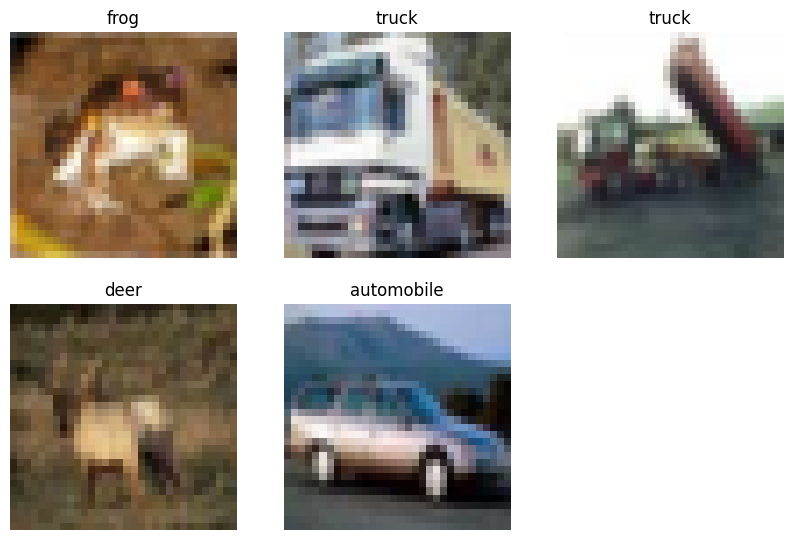

In [51]:
from data_preprocessing_utils import display_images
from data_preprocessing_utils import preprocess_images

# Extract data and labels
images = batch_data["data"]
labels = batch_data["labels"]

# TODO: Analyze this function
images_normalized = preprocess_images(images)

# CIFAR-10 class names
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Display images
display_images(images_normalized, labels, class_names, num_images=5)

Load all the dataset

In [52]:
from data_preprocessing_utils import load_cifar10_data

data_dir = "./cifar-10-python"

x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

print("x_train.shape =", x_train.shape)
print(type(x_train[0]))
print(type(x_train[0][0]))

print("y_train.shape =", y_train.shape)
print(type(y_train[0]))

print("x_test.shape =", x_test.shape)
print(type(x_test[0]))
print(type(x_test[0][0]))


print("y_test.shape =", y_test.shape)
print(type(y_test[0]))


x_train.shape = (50000, 3072)
<class 'numpy.ndarray'>
<class 'numpy.uint8'>
y_train.shape = (50000,)
<class 'numpy.int64'>
x_test.shape = (10000, 3072)
<class 'numpy.ndarray'>
<class 'numpy.uint8'>
y_test.shape = (10000,)
<class 'numpy.int64'>


Preprocess the training & testing data

In [53]:
from data_preprocessing_utils import normalize_data

# Normalize the data without reshaping
x_train_normalized = normalize_data(x_train)
x_test_normalized = normalize_data(x_test)

print("Normalized data shape:", x_train_normalized.shape)
print("First pixel value before normalization:", x_train[0, 0])
print("First pixel value after normalization:", x_train_normalized[0, 0])

Normalized data shape: (50000, 3072)
First pixel value before normalization: 59
First pixel value after normalization: 0.23137255


#### Dimensionality reduction

There is a reduction of dimensions with the PCA technique while maintaining 90% of the distribution. The dimension of the data is reduced from 3072 to 99.

In [ ]:
from sklearn import decomposition
import numpy as np

pca = decomposition.PCA(n_components=0.9, svd_solver="full", random_state=0)
x_train_final = pca.fit_transform(x_train_normalized)
x_test = pca.transform(x_test_normalized)

print("x_train_final.shape =", x_train_final.shape)
print("x_test.shape =", x_test.shape)

x_train_final.shape = (50000, 99)
x_test.shape = (10000, 99)


#### Model evaluation

`grid_search` performs K-fold cross validation & evaluates for various parameter values. 

Accuracy is chosen as the evaluation metric, because the classes are weighted.

`plot_grid_search` generates plots for accuracy and training time. 

`evaluate_model` retrains the best model on the entire training set and evaluates it on the test set.

In [10]:
x_train_final

array([[ -6.401385  ,   2.7292392 ,   1.5017853 , ...,   0.45767307,
         -0.13893142,   0.15370497],
       [  0.8296962 ,  -0.94980043,   6.003777  , ...,  -0.49559587,
         -0.5425845 ,   0.29687223],
       [  7.730128  , -11.521966  ,  -2.7535856 , ...,   0.5191348 ,
         -0.497725  ,   0.01277725],
       ...,
       [  0.70727867, -11.342387  ,  -0.39387563, ...,  -0.4482185 ,
          0.16391174,  -0.22432664],
       [ 11.367843  ,  -3.3758426 ,   5.5662217 , ...,   0.34420693,
         -0.89742154,   0.87441874],
       [  4.192734  ,  -1.1840641 ,  -4.445934  , ...,  -0.11418322,
          0.29179427,   0.26403162]], dtype=float32)

In [11]:
final_results = []

##### Linear Kernel (C)

$ Loss = \mathbf{w}^T\mathbf{w} + C\sum_{k=1}^R\varepsilon_{k}\ $

Kernel: $ K(\mathbf{x}, \mathbf{x}') = \langle\mathbf{x},\mathbf{x}'\rangle $

In [ ]:
from sklearn import svm
from model_training_utils import grid_search

# TODO: Analyze all possible values C can take
param_dict = {"C": (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0)}

model = svm.SVC(kernel="linear")
results = grid_search(model, param_dict, x_train_final, y_train)

[1/7] {'C': 0.001}: train_acc = 0.4074, val_acc = 0.3990 | t = 146.7 sec = 2.4 min
[2/7] {'C': 0.005}: train_acc = 0.4182, val_acc = 0.4057 | t = 176.2 sec = 2.9 min
[3/7] {'C': 0.01}: train_acc = 0.4200, val_acc = 0.4060 | t = 197.6 sec = 3.3 min
[4/7] {'C': 0.05}: train_acc = 0.4214, val_acc = 0.4059 | t = 248.5 sec = 4.1 min
[5/7] {'C': 0.1}: train_acc = 0.4215, val_acc = 0.4057 | t = 272.1 sec = 4.5 min
[6/7] {'C': 0.5}: train_acc = 0.4216, val_acc = 0.4060 | t = 378.9 sec = 6.3 min
[7/7] {'C': 1.0}: train_acc = 0.4217, val_acc = 0.4062 | t = 612.2 sec = 10.2 min
Best params = {'C': 1.0}
Maximum validation accuracy = 0.4062


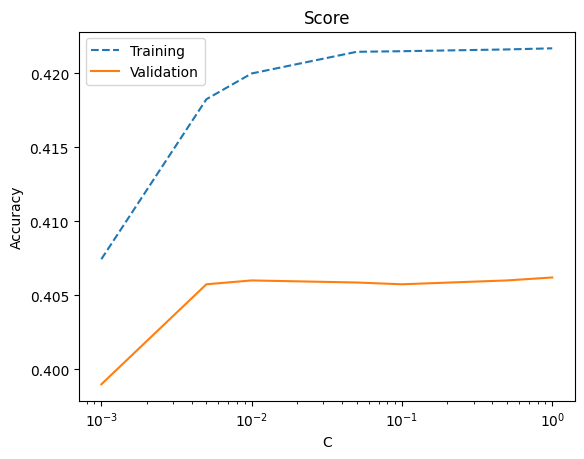

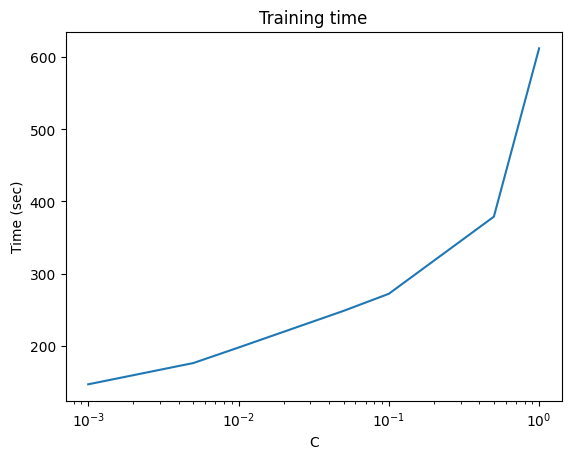

In [13]:
from model_training_utils import plot_grid_search

plot_grid_search(results, "C", None, "log")

In [14]:
from model_training_utils import evaluate_model

res = evaluate_model(
    "Linear SVM",
    model,
    results["best_params"],
    x_train_final,
    y_train,
    x_test,
    y_test,
)

final_results.append(res)

Training on the original training set with params = {'C': 1.0}
Training time = 981.5 sec = 16.4 min
Training accuracy = 0.4204
Test accuracy = 0.4077


##### Polynomial Kernel (C, degree)

Kernel: $ K(\mathbf{x}, \mathbf{x}') = (\gamma\langle\mathbf{x},\mathbf{x}'\rangle+r)^d $

In [15]:
from sklearn import svm

param_dict = {"C": (0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0), "degree": (2, 3, 4, 5)}

model = svm.SVC(kernel="poly")
results = grid_search(model, param_dict, x_train_final, y_train)

[1/28] {'C': 0.001, 'degree': 2}: train_acc = 0.1541, val_acc = 0.1527 | t = 316.4 sec = 5.3 min
[2/28] {'C': 0.001, 'degree': 3}: train_acc = 0.1759, val_acc = 0.1746 | t = 237.0 sec = 3.9 min
[3/28] {'C': 0.001, 'degree': 4}: train_acc = 0.1315, val_acc = 0.1297 | t = 280.5 sec = 4.7 min
[4/28] {'C': 0.001, 'degree': 5}: train_acc = 0.1497, val_acc = 0.1456 | t = 382.4 sec = 6.4 min
[5/28] {'C': 0.01, 'degree': 2}: train_acc = 0.2445, val_acc = 0.2406 | t = 274.8 sec = 4.6 min
[6/28] {'C': 0.01, 'degree': 3}: train_acc = 0.2800, val_acc = 0.2711 | t = 274.3 sec = 4.6 min
[7/28] {'C': 0.01, 'degree': 4}: train_acc = 0.1965, val_acc = 0.1856 | t = 300.3 sec = 5.0 min
[8/28] {'C': 0.01, 'degree': 5}: train_acc = 0.2203, val_acc = 0.1965 | t = 307.6 sec = 5.1 min
[9/28] {'C': 0.1, 'degree': 2}: train_acc = 0.3892, val_acc = 0.3654 | t = 259.5 sec = 4.3 min
[10/28] {'C': 0.1, 'degree': 3}: train_acc = 0.4376, val_acc = 0.3930 | t = 289.0 sec = 4.8 min
[11/28] {'C': 0.1, 'degree': 4}: trai

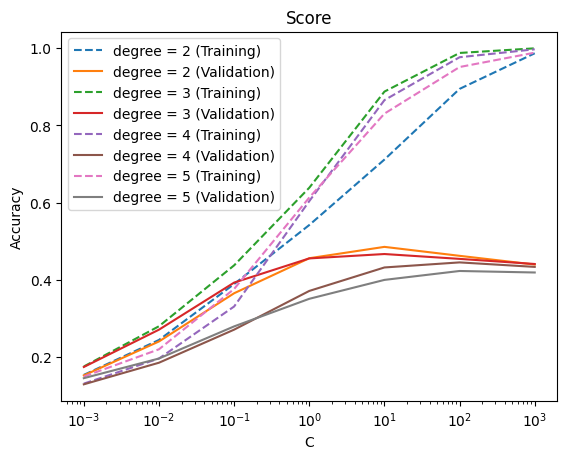

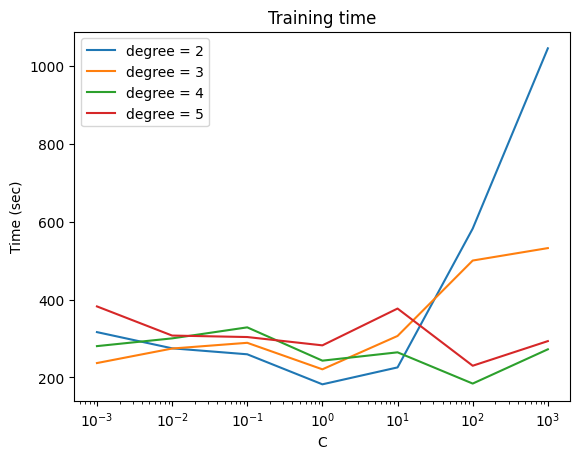

In [16]:
plot_grid_search(results, "C", "degree", "log")

In [17]:
res = evaluate_model(
    "Polynomial SVM",
    model,
    results["best_params"],
    x_train_final,
    y_train,
    x_test,
    y_test,
)

final_results.append(res)

Training on the original training set with params = {'C': 10.0, 'degree': 2}
Training time = 326.9 sec = 5.4 min
Training accuracy = 0.69724
Test accuracy = 0.4989


##### RBF Kernel (C, gamma)

Kernel: $ K(\mathbf{x}, \mathbf{x}') = e^{-\gamma||\mathbf{x}-\mathbf{x}'||^2} $

In [18]:
param_dict = {"C": (0.001, 0.01, 0.1, 1.0, 10.0, 100.0), "gamma": (0.01, 0.1, 1.0)}

model = svm.SVC(kernel="rbf")
results = grid_search(model, param_dict, x_train_final, y_train)

[1/18] {'C': 0.001, 'gamma': 0.01}: train_acc = 0.3023, val_acc = 0.2972 | t = 313.5 sec = 5.2 min
[2/18] {'C': 0.001, 'gamma': 0.1}: train_acc = 0.4875, val_acc = 0.1090 | t = 319.7 sec = 5.3 min
[3/18] {'C': 0.001, 'gamma': 1.0}: train_acc = 1.0000, val_acc = 0.1010 | t = 247.2 sec = 4.1 min
[4/18] {'C': 0.01, 'gamma': 0.01}: train_acc = 0.3462, val_acc = 0.3391 | t = 223.4 sec = 3.7 min
[5/18] {'C': 0.01, 'gamma': 0.1}: train_acc = 0.4875, val_acc = 0.1090 | t = 249.1 sec = 4.2 min
[6/18] {'C': 0.01, 'gamma': 1.0}: train_acc = 1.0000, val_acc = 0.1010 | t = 259.1 sec = 4.3 min
[7/18] {'C': 0.1, 'gamma': 0.01}: train_acc = 0.4824, val_acc = 0.4463 | t = 176.1 sec = 2.9 min
[8/18] {'C': 0.1, 'gamma': 0.1}: train_acc = 0.4882, val_acc = 0.1093 | t = 283.6 sec = 4.7 min
[9/18] {'C': 0.1, 'gamma': 1.0}: train_acc = 1.0000, val_acc = 0.1010 | t = 303.0 sec = 5.0 min
[10/18] {'C': 1.0, 'gamma': 0.01}: train_acc = 0.7569, val_acc = 0.5407 | t = 165.0 sec = 2.7 min
[11/18] {'C': 1.0, 'gamma'

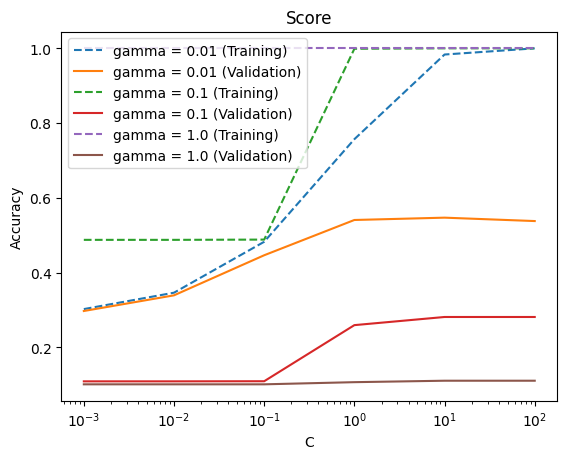

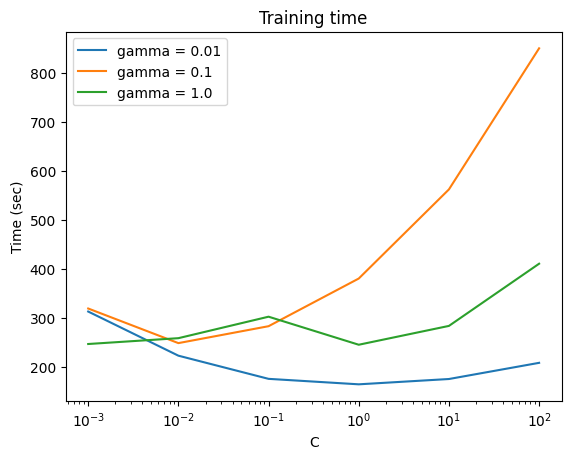

In [19]:
plot_grid_search(results, "C", "gamma", "log")

In [20]:
res = evaluate_model(
    "RBF Kernel", model, results["best_params"], x_train_final, y_train, x_test, y_test
)
final_results.append(res)

Training on the original training set with params = {'C': 10.0, 'gamma': 0.01}
Training time = 510.0 sec = 8.5 min
Training accuracy = 0.9809
Test accuracy = 0.5586


##### MLP Kernel (C, gamma)

Kernel: $ K(\mathbf{x}, \mathbf{x}') = tanh(\gamma\langle\mathbf{x},\mathbf{x}'\rangle+r) $

In [21]:
param_dict = {"C": (0.001, 0.01, 0.1, 1.0, 10.0, 100.0), "gamma": (0.001, 0.01, 0.1)}

model = svm.SVC(kernel="sigmoid")
results = grid_search(model, param_dict, x_train_final, y_train)

[1/18] {'C': 0.001, 'gamma': 0.001}: train_acc = 0.2478, val_acc = 0.2483 | t = 836.4 sec = 13.9 min
[2/18] {'C': 0.001, 'gamma': 0.01}: train_acc = 0.2504, val_acc = 0.2492 | t = 624.1 sec = 10.4 min
[3/18] {'C': 0.001, 'gamma': 0.1}: train_acc = 0.1895, val_acc = 0.1898 | t = 622.8 sec = 10.4 min
[4/18] {'C': 0.01, 'gamma': 0.001}: train_acc = 0.2810, val_acc = 0.2800 | t = 568.2 sec = 9.5 min
[5/18] {'C': 0.01, 'gamma': 0.01}: train_acc = 0.2635, val_acc = 0.2628 | t = 615.4 sec = 10.3 min
[6/18] {'C': 0.01, 'gamma': 0.1}: train_acc = 0.1424, val_acc = 0.1433 | t = 349.7 sec = 5.8 min
[7/18] {'C': 0.1, 'gamma': 0.001}: train_acc = 0.3659, val_acc = 0.3628 | t = 226.8 sec = 3.8 min
[8/18] {'C': 0.1, 'gamma': 0.01}: train_acc = 0.2032, val_acc = 0.2030 | t = 144.2 sec = 2.4 min
[9/18] {'C': 0.1, 'gamma': 0.1}: train_acc = 0.1426, val_acc = 0.1441 | t = 409.5 sec = 6.8 min
[10/18] {'C': 1.0, 'gamma': 0.001}: train_acc = 0.3865, val_acc = 0.3784 | t = 418.1 sec = 7.0 min
[11/18] {'C': 1

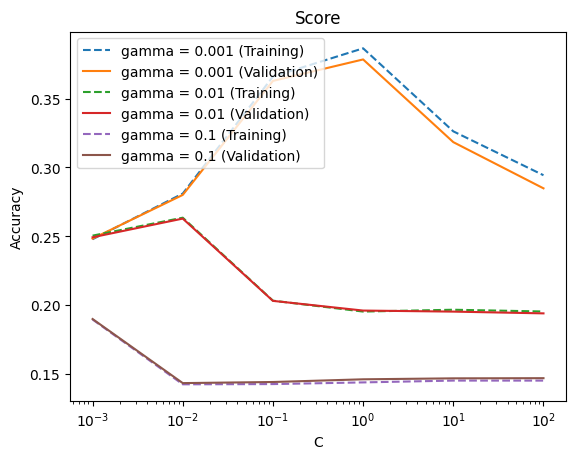

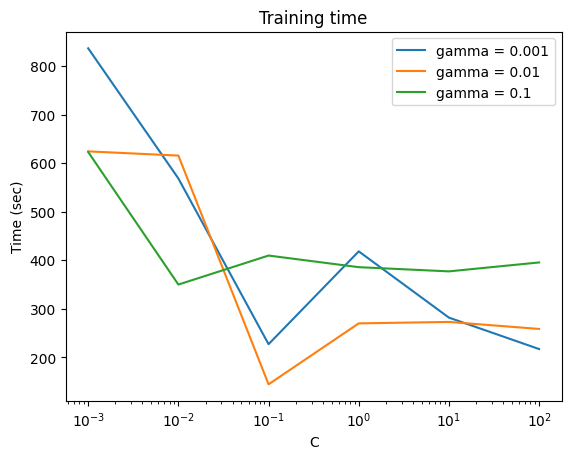

In [22]:
plot_grid_search(results, "C", "gamma", "log")

In [23]:
res = evaluate_model(
    "MLP Kernel",
    model,
    results["best_params"],
    x_train_final,
    y_train,
    x_test,
    y_test,
)
final_results.append(res)

Training on the original training set with params = {'C': 1.0, 'gamma': 0.001}
Training time = 1015.8 sec = 16.9 min
Training accuracy = 0.38522
Test accuracy = 0.3812


##### Nearest Neighbors

$d_p(\mathbf{x}, \mathbf{y}) = \sqrt[p]{\sum_{i}|x_i-y_i|^p}$

In [24]:
from sklearn import neighbors

param_dict = {"n_neighbors": (1, 2, 5, 10), "p": (1, 2, 3)}

model = neighbors.KNeighborsClassifier()
results = grid_search(model, param_dict, x_train_final, y_train)

[1/12] {'n_neighbors': 1, 'p': 1}: train_acc = 1.0000, val_acc = 0.3632 | t = 0.0 sec = 0.0 min
[2/12] {'n_neighbors': 1, 'p': 2}: train_acc = 1.0000, val_acc = 0.3757 | t = 0.0 sec = 0.0 min
[3/12] {'n_neighbors': 1, 'p': 3}: train_acc = 1.0000, val_acc = 0.3703 | t = 0.0 sec = 0.0 min
[4/12] {'n_neighbors': 2, 'p': 1}: train_acc = 0.6440, val_acc = 0.3186 | t = 0.0 sec = 0.0 min
[5/12] {'n_neighbors': 2, 'p': 2}: train_acc = 0.6618, val_acc = 0.3369 | t = 0.0 sec = 0.0 min
[6/12] {'n_neighbors': 2, 'p': 3}: train_acc = 0.6651, val_acc = 0.3333 | t = 0.0 sec = 0.0 min
[7/12] {'n_neighbors': 5, 'p': 1}: train_acc = 0.5208, val_acc = 0.3479 | t = 0.0 sec = 0.0 min
[8/12] {'n_neighbors': 5, 'p': 2}: train_acc = 0.5502, val_acc = 0.3738 | t = 0.0 sec = 0.0 min
[9/12] {'n_neighbors': 5, 'p': 3}: train_acc = 0.5538, val_acc = 0.3702 | t = 0.0 sec = 0.0 min
[10/12] {'n_neighbors': 10, 'p': 1}: train_acc = 0.4424, val_acc = 0.3444 | t = 0.0 sec = 0.0 min
[11/12] {'n_neighbors': 10, 'p': 2}: t

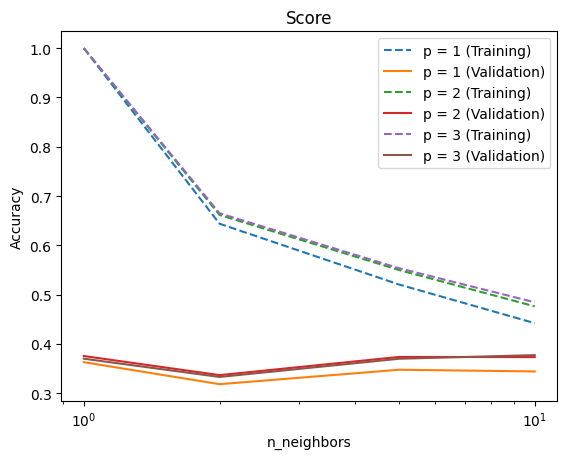

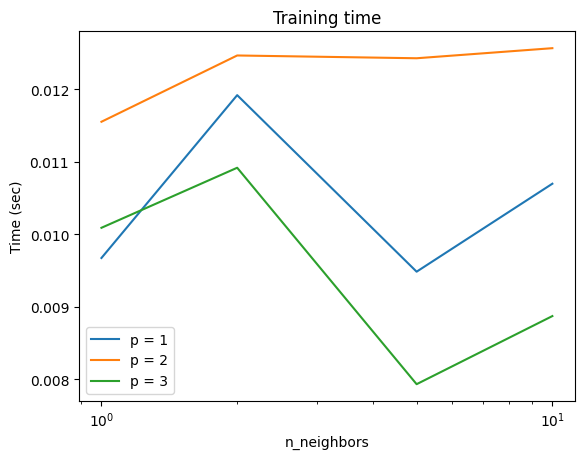

In [25]:
plot_grid_search(results, "n_neighbors", "p", "log")

In [26]:
res = evaluate_model(
    "Nearest Neighbors",
    model,
    results["best_params"],
    x_train_final,
    y_train,
    x_test,
    y_test,
)
final_results.append(res)

Training on the original training set with params = {'n_neighbors': 10, 'p': 3}
Training time = 0.0 sec = 0.0 min
Training accuracy = 0.49124
Test accuracy = 0.3893


##### Nearest Class Centroid

In [32]:
param_dict = {"shrink_threshold": (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)}

model = neighbors.NearestCentroid()
results = grid_search(model, param_dict, x_train_final, y_train)

[1/10] {'shrink_threshold': 0.1}: train_acc = 0.2689, val_acc = 0.2685 | t = 0.1 sec = 0.0 min
[2/10] {'shrink_threshold': 0.2}: train_acc = 0.2685, val_acc = 0.2679 | t = 0.1 sec = 0.0 min
[3/10] {'shrink_threshold': 0.3}: train_acc = 0.2682, val_acc = 0.2673 | t = 0.1 sec = 0.0 min
[4/10] {'shrink_threshold': 0.4}: train_acc = 0.2676, val_acc = 0.2670 | t = 0.1 sec = 0.0 min
[5/10] {'shrink_threshold': 0.5}: train_acc = 0.2671, val_acc = 0.2667 | t = 0.1 sec = 0.0 min
[6/10] {'shrink_threshold': 0.6}: train_acc = 0.2668, val_acc = 0.2662 | t = 0.1 sec = 0.0 min
[7/10] {'shrink_threshold': 0.7}: train_acc = 0.2664, val_acc = 0.2658 | t = 0.1 sec = 0.0 min
[8/10] {'shrink_threshold': 0.8}: train_acc = 0.2661, val_acc = 0.2654 | t = 0.1 sec = 0.0 min
[9/10] {'shrink_threshold': 0.9}: train_acc = 0.2656, val_acc = 0.2647 | t = 0.1 sec = 0.0 min
[10/10] {'shrink_threshold': 1.0}: train_acc = 0.2650, val_acc = 0.2642 | t = 0.1 sec = 0.0 min
Best params = {'shrink_threshold': 0.1}
Maximum v

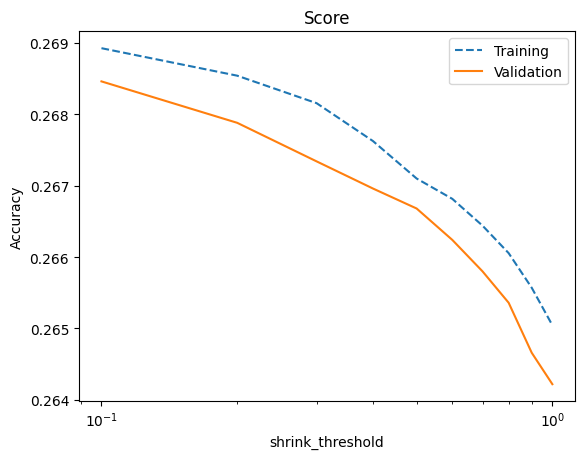

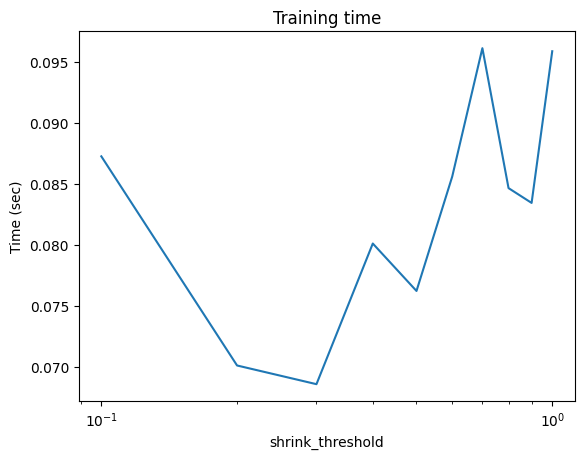

In [33]:
plot_grid_search(results, "shrink_threshold", None, "log")

In [34]:
res = evaluate_model(
    "Nearest Class Centroid",
    model,
    results["best_params"],
    x_train_final,
    y_train,
    x_test,
    y_test,
)
final_results.append(res)

Training on the original training set with params = {'shrink_threshold': 0.1}
Training time = 0.1 sec = 0.0 min
Training accuracy = 0.2689
Test accuracy = 0.2769


#### Results summary

In [46]:
import pandas as pd

final_results_df = pd.DataFrame(final_results)
print(final_results_df)


               Classifier                   Parameters Training Accuracy  \
0              Linear SVM                   C = 1.0000            0.4204   
1          Polynomial SVM      C = 10.0000, degree = 2            0.6972   
2              RBF Kernel  C = 10.0000, gamma = 0.0100            0.9809   
3              MLP Kernel   C = 1.0000, gamma = 0.0010            0.3852   
4       Nearest Neighbors      n_neighbors = 10, p = 3            0.4912   
5  Nearest Class Centroid    shrink_threshold = 0.1000            0.2689   

  Test Accuracy Training Time (sec)  
0        0.4077               981.5  
1        0.4989               326.9  
2        0.5586               510.0  
3        0.3812              1015.8  
4        0.3893                 0.0  
5        0.2769                 0.1  
